In [1]:
#dependencies
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#variables
# we will try multiple epsilon values 
n = 10000
epsillon = [.1,.05,.01]
probabilities = [.25, .5, .75, .1, .15]

In [3]:
class bandit_class:
    """
    bandit class
    """
    def __init__(self, prob, value = 0):
        self.prob = prob
        self.n = 0
        self.value = value
        
    def pull(self):
        return np.random.random() < self.prob
    
    def update(self, x):
        self.n += 1
        self.value = (1/self.n * (x - self.value)) + self.value
        
        

In [4]:
def experiment(n, epsillons, probabilities, plot = 0, annealing_eps = 0, optimistic_starts = 0, exploring_starts = 0):
        
    exploit = 0
    explore = 0
    epsilon_rewards = [[] for i in epsillons]
    greedy_rewards = []
    random_rewards = []
    annealing_rate = 1/(n/10)
    min_eps = 0.0001 #never want to fully stop exploring in case of some weirdness...
    arms = len(epsillons)
    
    
    #eps greedy
    for i in range(len(epsillons)):
        epsillon = epsillons[i] 
        
        if annealing_eps:
            epsillon = max(epsillon - (epsillons[i] * annealing_rate)  ,  min_eps)             
        
        bandits = [bandit_class(i, optimistic_starts) for i in probabilities]
        current_reward = 0
        
        #exploring starts, pull each arm how ever many times the variable is set to
        if exploring_starts:
            for selection in range(arms):
                for j in range(exploring_starts):
                    #pull selection
                    reward = bandits[selection].pull()

                    #update selection
                    bandits[selection].update(reward)   

                    #update running reward
                    current_reward += reward
                    epsilon_rewards[i].append(current_reward)
        
        for j in range(n - (exploring_starts*arms)):              
            
            #get max value
            max_arm = np.argmax([k.value for k in bandits])

            #if explore pick non optimal action
            if np.random.random() < epsillon:
                options = [l for l in range(len(bandits))]
                del options[max_arm]
                selection = np.random.choice(options)
                explore += 1
            else:
                selection = max_arm
                exploit += 1

            #pull selection
            reward = bandits[selection].pull()

            #update selection
            bandits[selection].update(reward)


            #update running reward
            current_reward += reward
            epsilon_rewards[i].append(current_reward)
        
    #ucb 1
    bandits = [bandit_class(i, optimistic_starts) for i in probabilities]
    current_reward = 0
    #exploring starts, pull each arm how ever many times the variable is set to
    if exploring_starts:
        for selection in range(arms):
            for j in range(exploring_starts):
                #pull selection
                reward = bandits[selection].pull()

                #update selection
                bandits[selection].update(reward)   

                #update running reward
                current_reward += reward
                greedy_rewards.append(current_reward)

    for j in range(n - (exploring_starts*arms)):
        
        #get max value
        selection = np.argmax([k.value + (np.sqrt((2* np.log(j + (exploring_starts*arms)))/k.n)) for k in bandits])
            
        #pull selection
        reward = bandits[selection].pull()
        
        #update selection
        bandits[selection].update(reward)        
        
        #update running reward
        current_reward += reward
        greedy_rewards.append(current_reward)
        
    #random
    bandits = [bandit_class(i) for i in probabilities]
    current_reward = 0
    for i in range(n):
        
        #randomly select arm
        options = [j for j in range(len(bandits))]
        selection = np.random.choice(options)
            
        #pull selection
        reward = bandits[selection].pull()
        
        #update selection
        bandits[selection].update(reward)        
        
        #update running reward
        current_reward += reward
        random_rewards.append(current_reward)
        
    if plot:
        #plot results
        for i in range(len(epsillons)):
            epsillon = epsillons[i]
            plt.plot(epsilon_rewards[i], label = 'epsilon: ' + str(epsillon))
        plt.plot(greedy_rewards, label = 'greedy ucb1')
        plt.plot(random_rewards, label = 'random')  
        plt.title('score over experiment run')
        plt.legend()
        plt.show()
    
    return [epsilon_rewards[i][-1] for i in range(len(epsillons))], greedy_rewards[-1], random_rewards[-1]


<ipython-input-4-df64b46eb0bb>:83: RuntimeWarning: divide by zero encountered in double_scalars
  selection = np.argmax([k.value + (np.sqrt((2* np.log(j + (exploring_starts*arms)))/k.n)) for k in bandits])


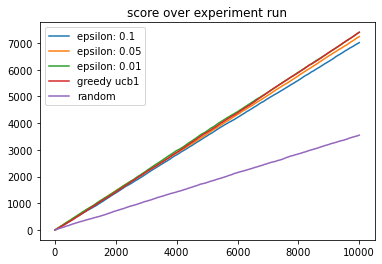

([7017, 7242, 7403], 7405, 3551)

In [5]:
experiment(10000, epsillon, probabilities, plot = 1, annealing_eps = 1, optimistic_starts = 0, exploring_starts = 10)

<ipython-input-4-df64b46eb0bb>:83: RuntimeWarning: divide by zero encountered in double_scalars
  selection = np.argmax([k.value + (np.sqrt((2* np.log(j + (exploring_starts*arms)))/k.n)) for k in bandits])


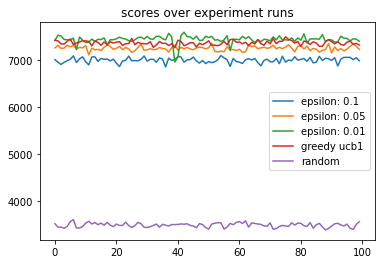

In [6]:
#run experiment 100 times to see how the scores fluctuate with different methods
#annealing epsilon rate
#eps decays over time
#ucb2
#exploring starts will pull each arm before doing value based selection as many times as the value is set to
def multiple_runs(n):
    epsilon_rewards = [[] for i in epsillon]
    greedy_rewards = []
    random_rewards = []
    for i in range(n):
        eps, greed, rand = experiment(10000, epsillon, probabilities, plot = 0, annealing_eps = 1, optimistic_starts = 0, exploring_starts = 10) 
        
        for j in range(len(epsillon)):
            epsilon_rewards[j].append(eps[j])
        greedy_rewards.append(greed)
        random_rewards.append(rand)
    
    #plot results
    for k in range(len(epsillon)):
        epsi = epsillon[k]
        plt.plot(epsilon_rewards[k], label = 'epsilon: ' + str(epsi))
    plt.plot(greedy_rewards, label = 'greedy ucb1')
    plt.plot(random_rewards, label = 'random') 
    plt.title('scores over experiment runs')
    plt.legend()
    plt.show()   
    
multiple_runs(100)

different combinations of controls and algorithms produce different results.

In [7]:
#ucb1 performs more cosnsitently over many runs versus other methods